
# ОИАД — Лабораторная работа №2

N == 5

In [68]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def hline():
    print('-' * 80)

def describe_series(s: pd.Series, name: str):
    print(f"Описательные статистики: {name}")
    print(s.describe())
    print("Количество пропусков:", s.isna().sum())
    hline()

def fechner_correlation(x: pd.Series, y: pd.Series, drop_zero: bool = True):
    xm = x.median()
    ym = y.median()
    dx = np.sign(x - xm)
    dy = np.sign(y - ym)
    m = pd.DataFrame({'dx': dx, 'dy': dy}).dropna()
    if drop_zero:
        m = m[(m['dx'] != 0) & (m['dy'] != 0)]
    n = len(m)
    same_sign = (m['dx'] == m['dy']).sum()
    r_f = (same_sign - (n - same_sign)) / n
    return r_f, n

def pearson_with_ci(x: np.ndarray, y: np.ndarray, alpha: float = 0.05):
    x = np.asarray(x)
    y = np.asarray(y)
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    n = x.size
    if n < 3:
        return np.nan, (np.nan, np.nan), n, np.nan
    r = np.corrcoef(x, y)[0, 1]
    r_scipy, pval = stats.pearsonr(x, y)
    r = r_scipy
    r_clipped = np.clip(r, -0.999999, 0.999999)
    z = np.arctanh(r_clipped)
    se = 1 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    z_low, z_high = z - z_crit * se, z + z_crit * se
    ci_low, ci_high = math.tanh(z_low), math.tanh(z_high)
    return r, (ci_low, ci_high), n, pval

def spearman_corr(x: np.ndarray, y: np.ndarray):
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    if x.size < 2:
        return np.nan, np.nan
    r, p = stats.spearmanr(x, y)
    return r, p

def kendall_corr(x: np.ndarray, y: np.ndarray):
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    if x.size < 2:
        return np.nan, np.nan
    tau, p = stats.kendalltau(x, y)
    return tau, p

def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray, p_regressors: int, alpha: float = 0.05):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = y_true.size
    sse = float(np.sum((y_true - y_pred)**2))
    y_mean = float(np.mean(y_true))
    ssr = float(np.sum((y_pred - y_mean)**2))
    sst = float(np.sum((y_true - y_mean)**2))
    r2 = 1 - sse / sst if sst > 0 else np.nan
    df1 = p_regressors
    df2 = max(n - p_regressors - 1, 1)
    msr = ssr / df1 if df1 > 0 else np.nan
    mse = sse / df2 if df2 > 0 else np.nan
    F = msr / mse if (msr is not np.nan and mse not in (0, np.nan)) else np.nan
    F_crit = stats.f.ppf(1 - alpha, df1, df2)
    p_val = stats.f.sf(F, df1, df2)
    return {
        'SSE': sse, 'SSR': ssr, 'SST': sst, 'R2': r2,
        'df1': df1, 'df2': df2, 'F': F, 'F_crit@alpha': F_crit, 'p_value': p_val
    }

In [69]:

N = 5
idx1 = N % 5
idx2 = (N**2) % 5 + 5
print(f"N={N} -> idx1={idx1}, idx2={idx2}")

CANDIDATE_PATHS = [
    "students_simple.csv"
]

df = None
df = pd.read_csv(CANDIDATE_PATHS[0])
data_path = p

print("Размерность:", df.shape)
print("Первые 5 строк:")
display(df.head())
hline()

cols = list(df.columns)
x_col = cols[idx1]
y_col = cols[idx2]

print(f"Выбранные признаки: X = '{x_col}' (столбец {idx1}), Y = '{y_col}' (столбец {idx2})")


N=5 -> idx1=0, idx2=5
Размерность: (20, 10)
Первые 5 строк:


,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


--------------------------------------------------------------------------------
Выбранные признаки: X = 'height' (столбец 0), Y = 'age' (столбец 5)


In [70]:

x_raw = pd.to_numeric(df[x_col], errors='coerce')
y_raw = pd.to_numeric(df[y_col], errors='coerce')
pair = pd.DataFrame({'x': x_raw, 'y': y_raw}).dropna()
pair_corr = pair.copy()

print("Число наблюдений для корреляционного анализа:", len(pair_corr))
describe_series(pair_corr['x'], f"X = {x_col}")
describe_series(pair_corr['y'], f"Y = {y_col}")


Число наблюдений для корреляционного анализа: 20
Описательные статистики: X = height
count     20.000000
mean     170.850000
std        8.585637
min      159.000000
25%      163.500000
50%      170.500000
75%      176.000000
max      192.000000
Name: x, dtype: float64
Количество пропусков: 0
--------------------------------------------------------------------------------
Описательные статистики: Y = age
count    20.00000
mean     23.40000
std       3.63318
min      19.00000
25%      20.00000
50%      23.00000
75%      26.25000
max      30.00000
Name: y, dtype: float64
Количество пропусков: 0
--------------------------------------------------------------------------------


In [71]:
r_fechner, n_fechner = fechner_correlation(pair_corr['x'], pair_corr['y'], drop_zero=True)

r_p, (ci_lo, ci_hi), n_p, pval_p = pearson_with_ci(pair_corr['x'].to_numpy(), pair_corr['y'].to_numpy(), alpha=0.05)

r_s, pval_s = spearman_corr(pair_corr['x'].to_numpy(), pair_corr['y'].to_numpy())

r_k, pval_k = kendall_corr(pair_corr['x'].to_numpy(), pair_corr['y'].to_numpy())

corr_table = pd.DataFrame({
    'Метод': ['Фехнера', 'Пирсона (r)', 'Спирмена (ρ)', 'Кендалла (τ)'],
    'Значение': [r_fechner, r_p, r_s, r_k],
    'n (исп.)': [n_fechner, n_p, len(pair_corr), len(pair_corr)],
    'p-value': [np.nan, pval_p, pval_s, pval_k],
    '95% ДИ (только Пирсон)': [
        '', f'[{ci_lo:.4f}; {ci_hi:.4f}]' if not np.isnan(ci_lo) else 'н/д', '', ''
    ]
})
corr_table


,Метод,Значение,n (исп.),p-value,95% ДИ (только Пирсон)
0,Фехнера,0.111111,18,NaN,
1,Пирсона (r),0.194375,20,0.411547,[-0.2715; 0.5865]
2,Спирмена (ρ),0.175023,20,0.460482,
3,Кендалла (τ),0.122290,20,0.469782,



## 2. Визуализация
Гистограммы для каждого признака и график рассеяния.


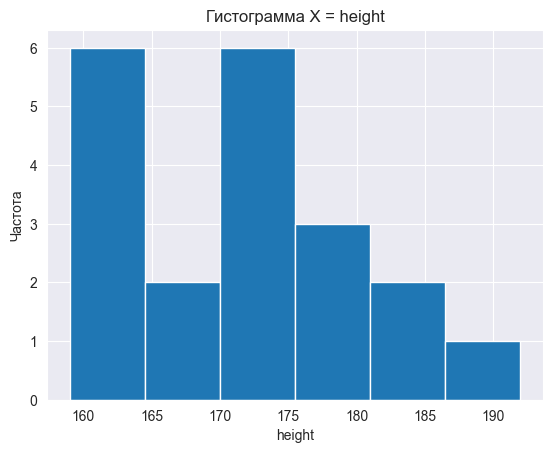

In [72]:

plt.figure()
plt.hist(pair_corr['x'].to_numpy(), bins='auto')
plt.title(f"Гистограмма X = {x_col}")
plt.xlabel(x_col)
plt.ylabel("Частота")
plt.grid(True)
plt.show()


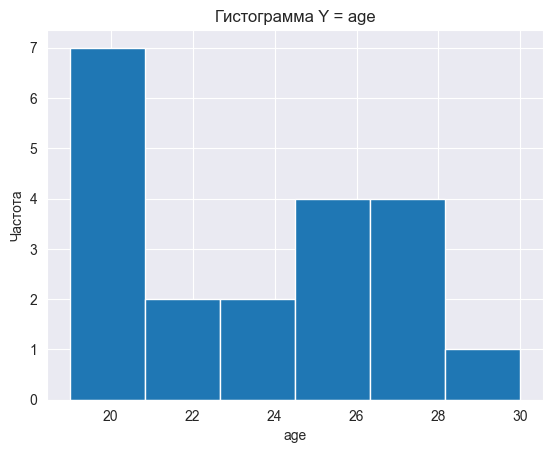

In [73]:

plt.figure()
plt.hist(pair_corr['y'].to_numpy(), bins='auto')
plt.title(f"Гистограмма Y = {y_col}")
plt.xlabel(y_col)
plt.ylabel("Частота")
plt.grid(True)
plt.show()


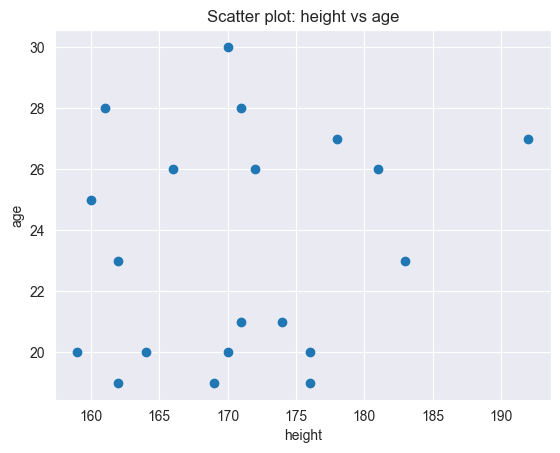

In [74]:

plt.figure()
plt.scatter(pair_corr['x'].to_numpy(), pair_corr['y'].to_numpy(), marker='o')
plt.title(f"Scatter plot: {x_col} vs {y_col}")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.grid(True)
plt.show()



## 3. Уравнения регрессии


In [75]:

pair_model = pair_corr.copy()
mask_common = (~pair_model['x'].isna()) & (~pair_model['y'].isna()) & (pair_model['x'] != 0) & (pair_model['y'] > 0)
pair_model = pair_model[mask_common].copy()
pair_model.reset_index(drop=True, inplace=True)

x = pair_model['x'].to_numpy()
y = pair_model['y'].to_numpy()

x_grid = np.linspace(np.min(x), np.max(x), 200)


In [76]:


results = {}

coef_lin = np.polyfit(x, y, deg=1)
w1_lin, w0_lin = coef_lin[0], coef_lin[1]
y_pred_lin = w1_lin * x + w0_lin
y_grid_lin = w1_lin * x_grid + w0_lin
results['Линейная'] = {
    'params': {'w1': w1_lin, 'w0': w0_lin},
    'y_pred': y_pred_lin,
    'y_grid': y_grid_lin,
    'p_regressors': 1
}

coef_quad = np.polyfit(x, y, deg=2)
w2_q, w1_q, w0_q = coef_quad[0], coef_quad[1], coef_quad[2]
y_pred_quad = w2_q * x**2 + w1_q * x + w0_q
y_grid_quad = w2_q * x_grid**2 + w1_q * x_grid + w0_q
results['Квадратичная'] = {
    'params': {'w2': w2_q, 'w1': w1_q, 'w0': w0_q},
    'y_pred': y_pred_quad,
    'y_grid': y_grid_quad,
    'p_regressors': 2
}

z = 1.0 / x
coef_hyp = np.polyfit(z, y, deg=1)
w1_hyp, w0_hyp = coef_hyp[0], coef_hyp[1]
y_pred_hyp = w1_hyp * (1.0 / x) + w0_hyp
y_grid_hyp = w1_hyp * (1.0 / x_grid) + w0_hyp
results['Гиперболическая'] = {
    'params': {'w1': w1_hyp, 'w0': w0_hyp},
    'y_pred': y_pred_hyp,
    'y_grid': y_grid_hyp,
    'p_regressors': 1  # 1/x
}

lny = np.log(y)
coef_exp = np.polyfit(x, lny, deg=1)  # [ln(w1), ln(w0)]
lnw1, lnw0 = coef_exp[0], coef_exp[1]
w1_exp = np.exp(lnw1)
w0_exp = np.exp(lnw0)
y_pred_exp = w0_exp * (w1_exp ** x)
y_grid_exp = w0_exp * (w1_exp ** x_grid)
results['Показательная'] = {
    'params': {'w1': w1_exp, 'w0': w0_exp},
    'y_pred': y_pred_exp,
    'y_grid': y_grid_exp,
    'p_regressors': 1  # x
}

params_rows = []
for name, info in results.items():
    row = {'Модель': name}
    for k, v in info['params'].items():
        row[k] = v
    params_rows.append(row)

params_df = pd.DataFrame(params_rows).set_index('Модель')
display(params_df)
hline()


,w1,w0,w2
Модель,,,
Линейная,0.082253,9.347007,NaN
Квадратичная,-1.771474,169.689090,0.005344
Гиперболическая,-2351.711253,37.197016,NaN
Показательная,1.003621,12.475464,NaN


--------------------------------------------------------------------------------


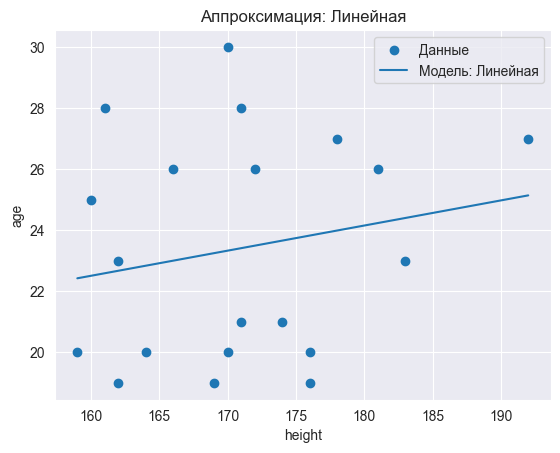

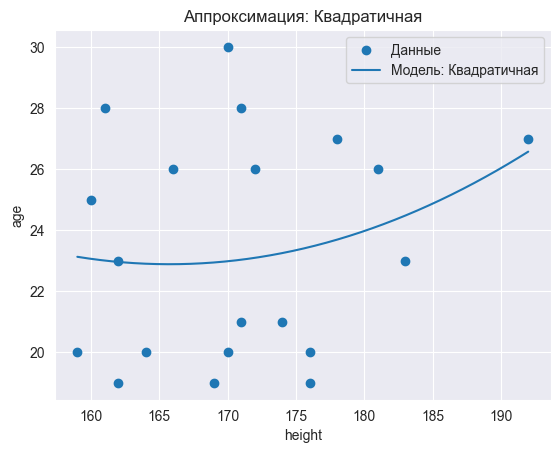

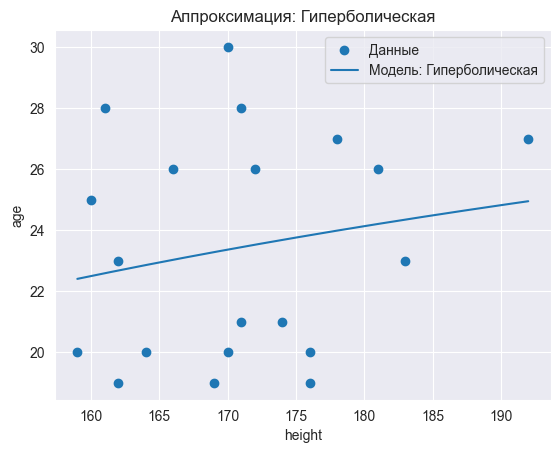

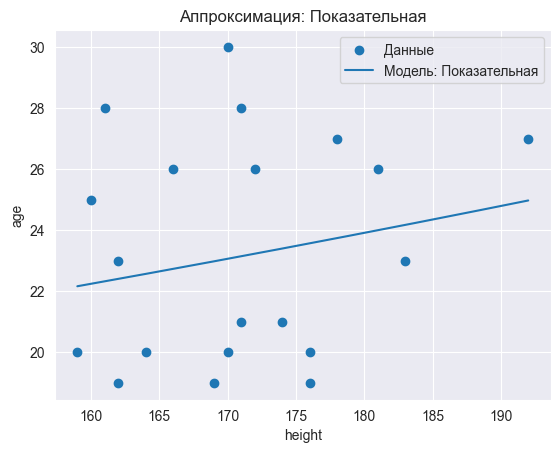

In [77]:

for model_name, info in results.items():
    plt.figure()
    plt.scatter(x, y, marker='o', label='Данные')
    plt.plot(x_grid, info['y_grid'], label=f'Модель: {model_name}')
    plt.title(f"Аппроксимация: {model_name}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.legend()
    plt.show()



## 4. Проверка уравнений регрессии по кр Фишера


In [78]:

metrics_rows = []
for name, info in results.items():
    m = regression_metrics(y_true=y, y_pred=info['y_pred'], p_regressors=info['p_regressors'], alpha=0.05)
    metrics_rows.append({'Модель': name, **m})

metrics_df = pd.DataFrame(metrics_rows).set_index('Модель').sort_values('R2', ascending=False)
display(metrics_df)

best_model = metrics_df.index[0]
worst_model = metrics_df.index[-1]

print(f"Лучшая модель по R^2: {best_model}")
print(f"Худшая модель по R^2: {worst_model}")


,SSE,SSR,SST,R2,df1,df2,F,F_crit@alpha,p_value
Модель,,,,,,,,,
Квадратичная,236.780805,14.019195,250.8,0.055898,2,17,0.503264,3.591531,0.613283
Линейная,241.324408,9.475592,250.8,0.037781,1,18,0.706769,4.413873,0.411547
Гиперболическая,242.101442,8.698558,250.8,0.034683,1,18,0.646729,4.413873,0.431778
Показательная,242.368462,11.287549,250.8,0.033619,1,18,0.838293,4.413873,0.371989


Лучшая модель по R^2: Квадратичная
Худшая модель по R^2: Показательная



## 5. Выводы
Лучшая форма аппроксимации - квадратичная, худшая - показательная